
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields)

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4929520.datarmor0/parcels-502090/libparcels_random_114ba1a4-7783-4ad4-a07a-d40c846a1183.so


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=3)
#
client = Client(cluster)



In [3]:
client

Client Scheduler: tcp://127.0.0.1:55879 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


### Load data

In [4]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()

In [6]:
ds_Lstats

<xarray.Dataset>
Dimensions:                        (lat: 179, lon: 359)
Coordinates:
  * lat                            (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
  * lon                            (lon) float64 -179.5 -178.5 ... 177.5 178.5
Data variables: (12/19)
    area                           (lon, lat) float64 nan 49.22 ... 28.8 49.22
    mean_meridional_velocity       (lon, lat) float64 nan nan nan ... nan nan
    mean_meridional_velocity_sq    (lon, lat) float64 nan nan nan ... nan nan
    mean_velocity_amplitude        (lon, lat) float64 nan nan nan ... nan nan
    mean_velocity_amplitude_sq     (lon, lat) float64 nan nan nan ... nan nan
    mean_zonal_velocity            (lon, lat) float64 nan nan nan ... nan nan
    ...                             ...
    velocity_amplitude_iprime_sq   (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_sq          (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity                 (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_iprime          (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_iprime_sq       (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_sq              (lon, lat) float64 nan nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

In [8]:
# Eulerian data
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds = ds.compute()

In [9]:
# Rotation velocity field
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [10]:
# Mean Eulerian field Dataset
ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

In [39]:
# Binning the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 0.1
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

N = histogram(ds_mean.lon, ds_mean.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)

In [115]:
MKE_0 = MKE_0.groupby_bins('lat',lat).mean()

KeyError: 'lat'

In [ ]:
MKE_0

In [119]:
ds_sub.groupby_bins('lon',lon)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [13]:
ds_mean['mean_velocity_amplitude'] = np.sqrt(ds_mean.zonal_velocity_mean**2+ds_mean.meridional_velocity_mean**2)

In [14]:

ds_sub = ds_mean.mean_velocity_amplitude.isel(face=0) 
lon = np.arange(ds_sub.lon.min(),ds_sub.lon.max(),dl)
lat = np.arange(ds_sub.lat.min(),ds_sub.lat.max(),dl)
#MKE_0 = ds_sub.groupby_bins('lon',lon).mean(['lon_bins'])


In [15]:
MKE_0 = ds_sub.groupby_bins('lon',lon).mean()

In [30]:
ds_other = xr.DataArray(ds_sub.values,dims=['lon','lat'],coords={'lon':ds_sub.lon.values.flatten(),'lat':ds_sub.lat.values.flatten()})

ValueError: conflicting sizes for dimension 'lon': length 4320 on the data but length 18662400 on coordinate 'lon'

In [18]:
ds_grouped = ds_sub.groupby_bins('lon',lon)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

In [ ]:
ds_grouped

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [64]:
MKE = ds_mean.mean_velocity_amplitude.groupby_bins('lon',lon).mean()
MKE = MKE.groupby_bins('lat',lat).mean()

In [92]:
MKE

<xarray.DataArray 'mean_velocity_amplitude' (face: 13, j_bins: 179, i_bins: 359)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.11295856,
         0.11179921, 0.1107053 ],
        [       nan,        nan,        nan, ..., 0.11284499,
         0.11173584, 0.11059909],
        [       nan,        nan,        nan, ..., 0.11273904,
         0.11180226, 0.11062598]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.07497557,
         0.07005271, 0.06644852],
        [       nan,        nan,        nan, ..., 0.07670704,
         0.07169642, 0.06751333],
        [       nan,        nan,        nan, ..., 0.07791936,
         0.07284715, 0.06817439]]], dtype=float32)
Coordinates:
  * j_bins   (j_bins) object (-90.0, -89.0] (-89.0, -88.0] ... (88.0, 89.0]
  * i_bins   (i_bins) object (-180.0, -179.0] ... (178.0, 179.0]
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12

In [96]:
ds_ke = xr.Dataset({'mean_ke':(['face','lat_mid','lon_mid'],MKE.values)})#,coords={'face':MKE.face.values,'lat':MKE.lat_mid.values,'lon':MKE.lon_mid.values})

In [97]:
ds_ke['lat_mid'] = np.array([x.mid for x in MKE.j_bins.values])
ds_ke['lon_mid'] = np.array([x.mid for x in MKE.i_bins.values])

In [99]:
ds_ke['face'] = MKE.face.values

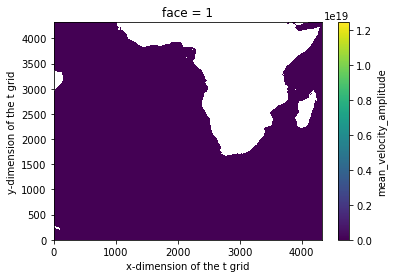

In [103]:
ds_mean.mean_velocity_amplitude.sel(face=1).plot()

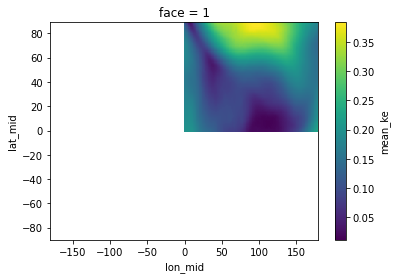

In [100]:
ds_ke.mean_ke.sel(face=1).plot(y='lat_mid',x='lon_mid')

### Mean kinetic energy : $<\sqrt{\bar u ^2+\bar v ^2}>$

In [25]:
ds_mean['mean_velocity_amplitude'] = np.sqrt(ds_mean.zonal_velocity_mean**2+ds_mean.meridional_velocity_mean**2)

In [40]:
MKE = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*ds_mean.mean_velocity_amplitude), 
                 dim=['i', 'j','face'],
                 block_size=None
                )

MKE_mean = (MKE/N).rename('MKE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Eulerian mean kinetic energy')

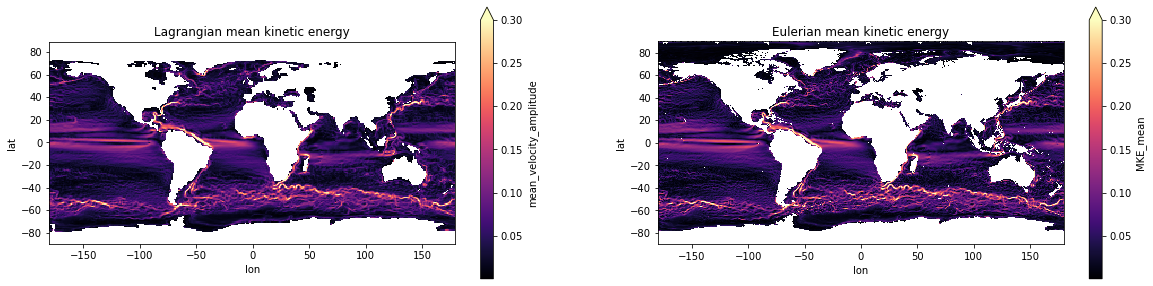

In [41]:
vmax = 0.3
colmap='magma'
fig,ax = plt.subplots(1,2,figsize=(20,5))
(0.5*ds_Lstats.mean_velocity_amplitude).plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[0])
ax[0].set_aspect('equal');ax[0].set_title('Lagrangian mean kinetic energy')
MKE_mean.plot(y='lat',vmax=vmax,cmap=colmap,ax=ax[1])
ax[1].set_aspect('equal');ax[1].set_title('Eulerian mean kinetic energy')

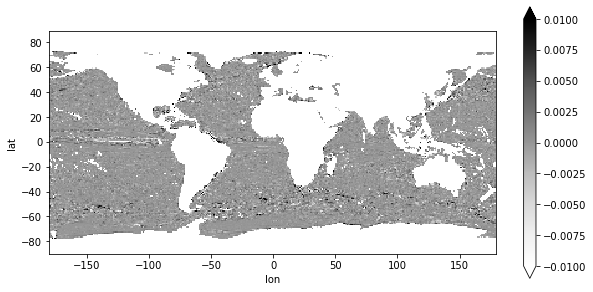

In [54]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
(0.5*ds_Lstats.mean_velocity_amplitude-MKE_mean).plot(y='lat',vmax=0.01,cmap='Greys',ax=ax)
ax.set_aspect('equal')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


{'fig': <Figure size 720x720 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aacc8c50610>}

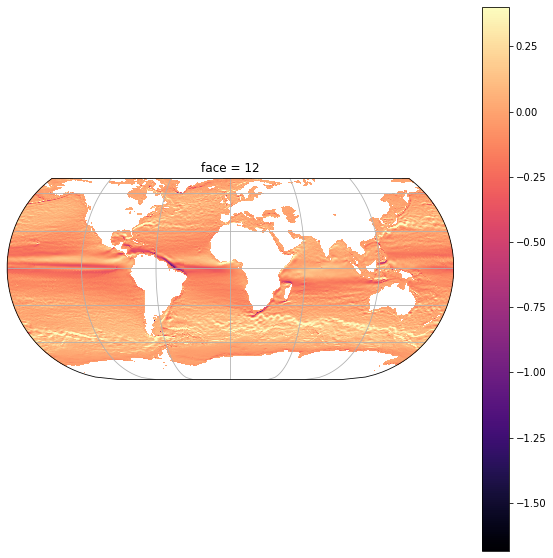

In [38]:
plot_pretty(ds_mean[V+'_mean'],colorbar=True,vmax=vmax,land=False,figsize=(10,10))

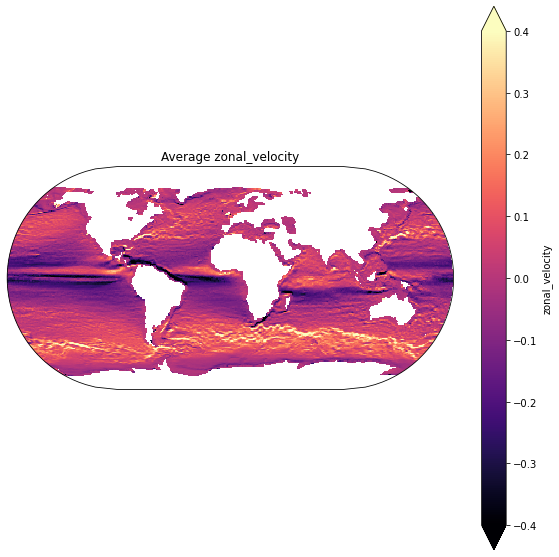

In [70]:
crs = ccrs.EckertIII()
#crs = ccrs.PlateCarree()
V = 'zonal_velocity'
vmax = 0.4
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=crs)


ds_Lstats[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
plt.title('Average '+V)
land_feature = cfeature.LAND
#ax.coastlines()
#ax.add_feature(land_feature, zorder=2)

In [71]:
zonal_v = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (ds_mean.zonal_velocity_mean), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
zonal_vmean = (zonal_v/N).rename('zonal_velocity_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Eulerian : Average zonal_velocity')

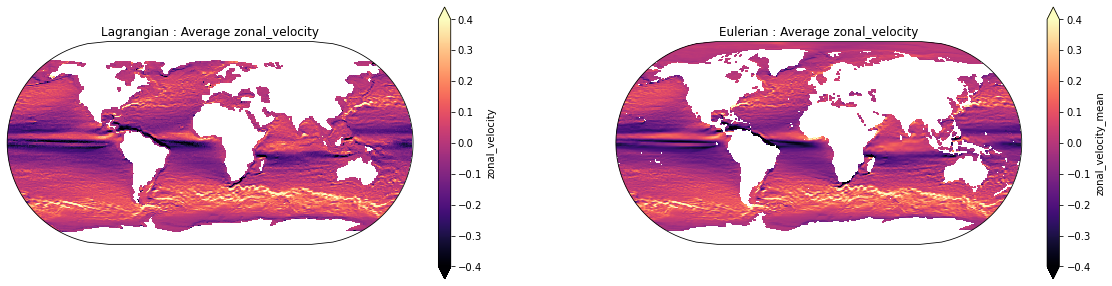

In [72]:
crs = ccrs.EckertIII()
#crs = ccrs.PlateCarree()
V = 'zonal_velocity'
vmax = 0.4
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121, projection=crs)


ds_Lstats[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree()
                    )
plt.title('Lagrangian : Average '+V)
ax = fig.add_subplot(122, projection=crs)
zonal_vmean.plot(y='lat',vmax=vmax,ax=ax,transform=ccrs.PlateCarree(),cmap='magma')

plt.title('Eulerian : Average '+V)

In [73]:
# Enquête trou en Eulerien

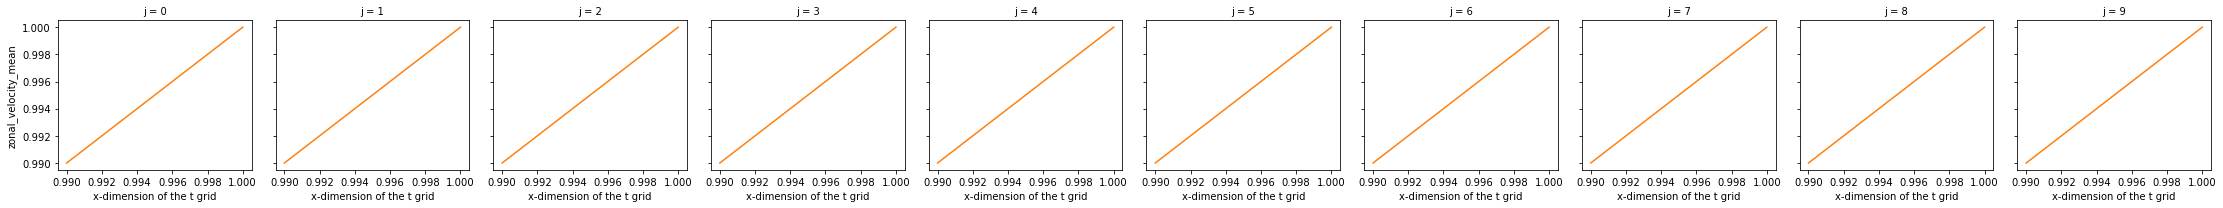

In [96]:
fg = ds_mean.isel(face=0).isel(i=slice(0,10),j=slice(0,10)).zonal_velocity_mean.plot(col='j')
for ax in fg.axes[0]:
    ax.plot(np.linspace(0.99,1),np.linspace(0.99,1))

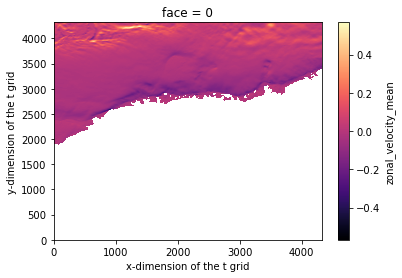

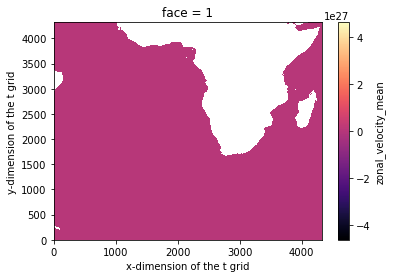

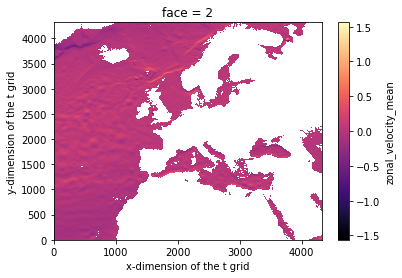

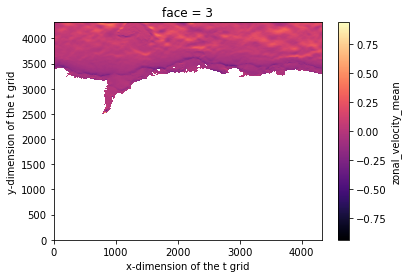

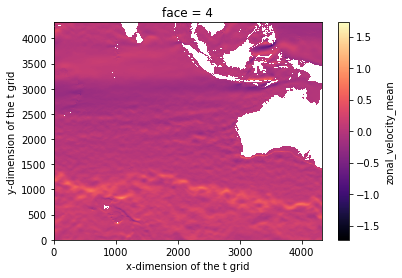

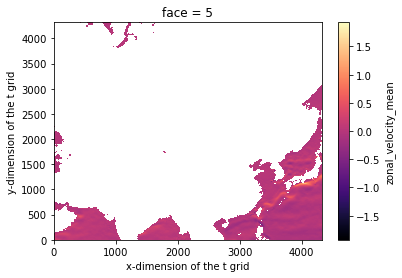

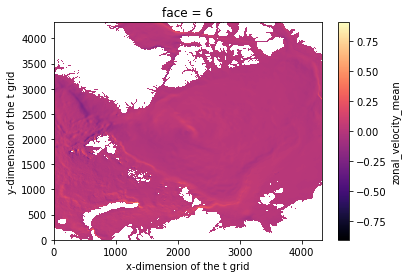

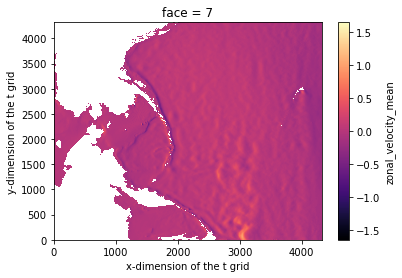

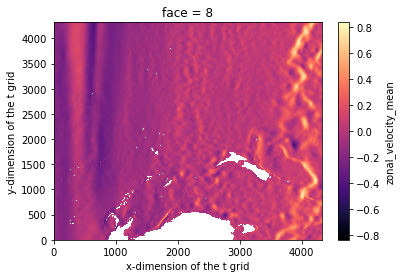

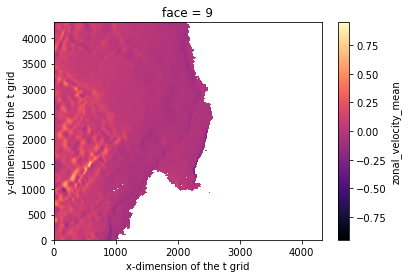

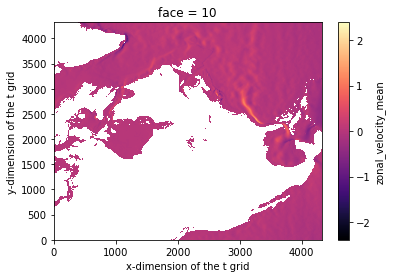

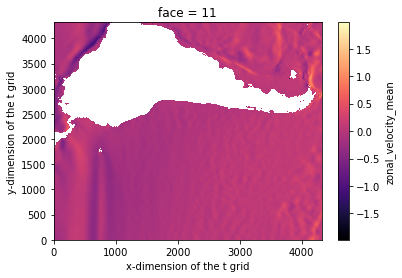

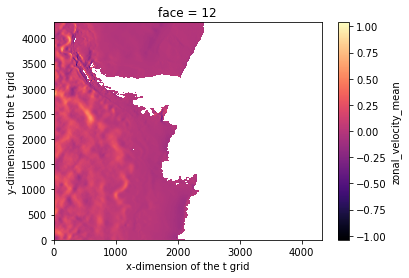

In [97]:
for face in np.arange(0,13):
    plt.figure()
    ds_mean.zonal_velocity_mean.isel(face=face).plot(cmap='magma')

In [56]:
meridional_v = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (ds_mean.meridional_velocity_mean), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
meridional_vmean = (meridional_v/N).rename('meridional_velocity_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

Text(0.5, 1.0, 'Eulerian : Average meridional_velocity')

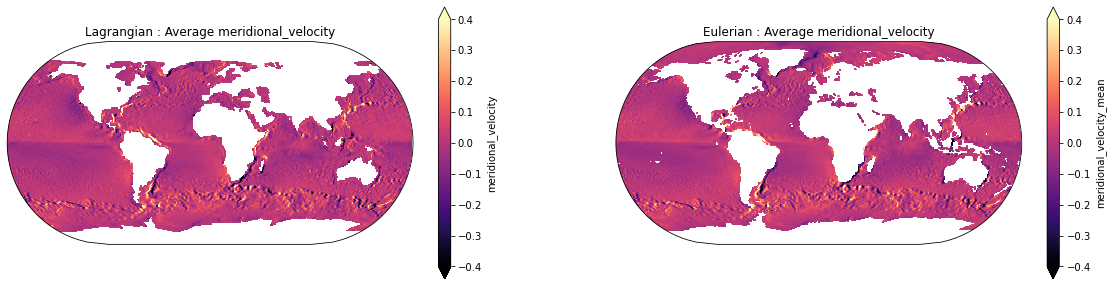

In [58]:
crs = ccrs.EckertIII()
#crs = ccrs.PlateCarree()
V = 'meridional_velocity'
vmax = 0.4
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121, projection=crs)


ds_Lstats[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree()
                    )
plt.title('Lagrangian : Average '+V)
ax = fig.add_subplot(122, projection=crs)
meridional_vmean.plot(y='lat',vmax=vmax,ax=ax,transform=ccrs.PlateCarree(),cmap='magma')

plt.title('Eulerian : Average '+V)

### Mean kinetic energy

In [60]:
KE = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (0.5*np.sqrt(ds_mean.zonal_velocity_mean**2+ds_mean.meridional_velocity_mean**2)), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
KE_mean = (KE/N).rename('KE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})

In [62]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, i: 1080, j: 1080)
Coordinates: (12/17)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                         (j) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
  * i                         (i) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
    dxC                       (face, j, i) float32 324.6 324.6 ... 480.3 479.5
    dyG                       (face, j, i) float32 479.0 479.1 ... 324.6 324.6
    rAw                       (face, j, i) float32 1.555e+05 ... 1.556e+05
    ...                        ...
    rA                        (face, j, i) float32 1.555e+05 ... 1.556e+05
    dxG                       (face, j, i) float32 324.6 324.6 ... 480.1 479.3
    dyC                       (face, j, i) float32 239.5 239.5 ... 324.6 324.6
    rAs                       (face, j, i) float32 7.774e+04 ... 1.556e+05
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.5
    lat                       (face, j, i) float64 -88.18 -88.19 ... -88.17
Data variables:
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    sea_level_mean            (face, j, i) float32 nan nan nan ... nan nan nan
    temperature_mean          (face, j, i) float32 nan nan nan ... nan nan nan
    salinity_mean             (face, j, i) float32 nan nan nan ... nan nan nan

Text(0.5, 1.0, 'Eulerian : MKE')

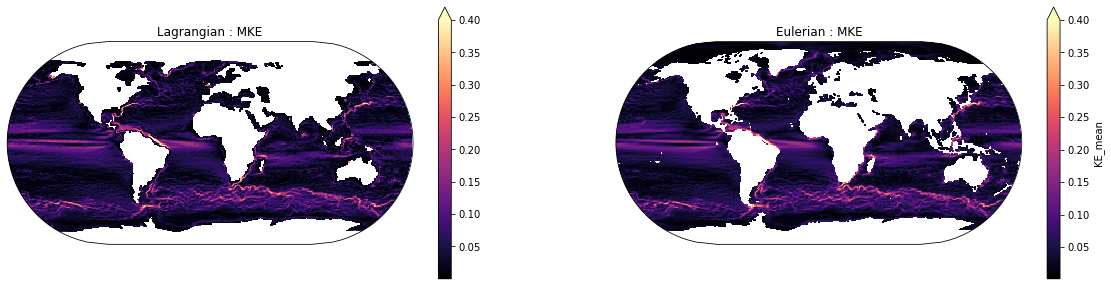

In [65]:
crs = ccrs.EckertIII()
#crs = ccrs.PlateCarree()

vmax = 0.4
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121, projection=crs)


(0.5*np.sqrt(ds_Lstats['zonal_velocity']**2+ds_Lstats['meridional_velocity']**2)).plot(x='lon', 
                     y='lat',
                     vmax=vmax,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree()
                    )
plt.title('Lagrangian : MKE')
ax = fig.add_subplot(122, projection=crs)
KE_mean.plot(y='lat',vmax=vmax,ax=ax,transform=ccrs.PlateCarree(),cmap='magma')
plt.title('Eulerian : MKE')


In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
